# In this notebook, we attempt in creating an attention based NN to predict the target on the timeseries alone. 

We first create an example, then we will generalize it and include it into training.py. 

# Import and preparations 

In [38]:
import sys, importlib
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import copy
import time

sys.path.append("../")
from proj_mod import training, data_processing, visualization
importlib.reload(training);
importlib.reload(data_processing);
importlib.reload(visualization);

In [39]:
device=(torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print(f"Using device {device}")

Using device cuda


# Data preparation 

### Load time id order

In [40]:
list_time=np.load("../processed_data/recovered_time_id_order.npy")

### Load timeseries 

In [41]:
df_RV_ts=pd.read_parquet("../processed_data/book_RV_ts_60_si.parquet")

### Load target 

In [42]:
df_target=pd.read_csv("../raw_data/kaggle_ORVP/train.csv")
df_target["row_id"]=df_target["stock_id"].astype(int).astype(str)+"-"+df_target["time_id"].astype(int).astype(str)
df_target

,stock_id,time_id,target,row_id
0,0,5,0.004136,0-5
1,0,11,0.001445,0-11
2,0,16,0.002168,0-16
3,0,31,0.002195,0-31
4,0,62,0.001747,0-62
...,...,...,...,...
428927,126,32751,0.003461,126-32751
428928,126,32753,0.003113,126-32753
428929,126,32758,0.004070,126-32758
428930,126,32763,0.003357,126-32763


### Create datasets 

In [43]:
time_split_list=data_processing.time_cross_val_split(list_time=list_time,n_split=1,percent_val_size=10,list_output=True)
train_time_id,test_time_id=time_split_list[0][0],time_split_list[0][1]

train_dataset=training.RVdataset(time_id_list=train_time_id,ts_features=["sub_int_RV"],tab_features=["emb_id"],df_ts_feat=df_RV_ts,df_target=df_target)
test_dataset=training.RVdataset(time_id_list=test_time_id,ts_features=["sub_int_RV"],tab_features=["emb_id"],df_ts_feat=df_RV_ts,df_target=df_target)

In fold 0 :

Train set end at 8117 .

Test set start at 15516 end at 10890 .



/home/machine2/Desktop/Realized_Volatility_Prediction_-erdos_deeplearning-/NNetwork/../proj_mod/training.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tab_copy["sub_int_num"]=np.nan
/home/machine2/Desktop/Realized_Volatility_Prediction_-erdos_deeplearning-/NNetwork/../proj_mod/training.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tab_copy["sub_int_num"]=np.nan


In [44]:
embed=nn.Embedding(num_embeddings=4,embedding_dim=2)
out=embed(torch.tensor([[0,1,2,3],[0,1,2,3]]))

In [45]:
out

tensor([[[-1.0153, -0.1476],
         [ 0.1772,  0.3560],
         [ 0.7680, -1.3964],
         [-0.3542, -0.3484]],

        [[-1.0153, -0.1476],
         [ 0.1772,  0.3560],
         [ 0.7680, -1.3964],
         [-0.3542, -0.3484]]], grad_fn=<EmbeddingBackward0>)

In [46]:
out.shape

torch.Size([2, 4, 2])

In [47]:
torch.tensor([0,1,2,3]).expand(2,4)

tensor([[0, 1, 2, 3],
        [0, 1, 2, 3]])

# Create example (encoder based only) transformer model 

In [48]:
class ts_encoder_example(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_attn=nn.MultiheadAttention(embed_dim=32,num_heads=4,dropout=0.1,batch_first=True)
        self.encoder_norm1=nn.LayerNorm(32)
        self.encoder_feedforward=nn.Sequential(
            nn.Linear(in_features=32,out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,out_features=32)
        )
        self.encoder_norm2=nn.LayerNorm(32)
        
    def forward(self,x):
        attn,_=self.encoder_attn(x,x,x)
        x=self.encoder_norm1(x+attn)
        attn=self.encoder_feedforward(x)
        return self.encoder_norm2(x+attn)
        

class ts_trans_example(nn.Module): 
    # An example where only encoder is used, the logic behind this is that we only want one value output, it might not be needed to add in decoders (which )
    def __init__(self):
        super().__init__()
        #Frozen conv 
        self.frozen_conv=training.frozen_diff_conv(n_diff=2) 
        #Position embedding 
        self.pos_emb=nn.Embedding(num_embeddings=60,embedding_dim=32) # 60 is the length of our (default) timeseries. 
        self.ts_proj=nn.Linear(in_features=3,out_features=32)
        self.pos_attn=nn.MultiheadAttention(embed_dim=32,batch_first=True,dropout=0.1,num_heads=4)
        self.pos_norm=nn.LayerNorm(32) 
        #Encoder stacking 
        self.encoder_layers=nn.ModuleList([
            ts_encoder_example()
            for _ in range(4)
        ])
        #Final feedforward 
        self.final_linear=nn.Linear(in_features=32,out_features=1)
        
        #scaler
        self.input_scaler=10000
        
    def forward(self,x): 
        #Create and reshape the timeseries tensor 
        x*=self.input_scaler
        x=torch.unsqueeze(x,dim=1)
        x=self.frozen_conv(x)
        x=x.permute(0,2,1) 
        # print(x.shape)
        x=self.ts_proj(x) # (N, 60, 32) 60 is the timeseries length 
        #Adding in position for positional impact 
        pos_id=torch.arange(60, device=x.device).expand(x.shape[0],60)
        pos_emb=self.pos_emb(pos_id)
        pos,_=self.pos_attn(x,pos_emb,pos_emb)
        x=x+pos
        x=self.pos_norm(x)
        #Run though the encoder layers 
        for layer in self.encoder_layers: 
            x=layer(x)
        return torch.sum(x,dim=1)/self.input_scaler # (N,1)
        
        
        

### Create loaders

In [49]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=512,shuffle=True, num_workers=4, pin_memory=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=512,shuffle=True, num_workers =4, pin_memory=True)

# Loss tracking
train_loss = []
val_loss = []

### Init model 

In [50]:
trans_example_mod=ts_trans_example().to(device=device)

import torch.optim as optim

optimizer = optim.Adam(trans_example_mod.parameters(), lr=1e-3)

In [51]:
from torchinfo import summary
summary(trans_example_mod)

Layer (type:depth-idx)                                       Param #
ts_trans_example                                             --
├─frozen_diff_conv: 1-1                                      --
│    └─Conv1d: 2-1                                           (2)
├─Embedding: 1-2                                             1,920
├─Linear: 1-3                                                128
├─MultiheadAttention: 1-4                                    3,168
│    └─NonDynamicallyQuantizableLinear: 2-2                  1,056
├─LayerNorm: 1-5                                             64
├─ModuleList: 1-6                                            --
│    └─ts_encoder_example: 2-3                               --
│    │    └─MultiheadAttention: 3-1                          4,224
│    │    └─LayerNorm: 3-2                                   64
│    │    └─Sequential: 3-3                                  4,192
│    │    └─LayerNorm: 3-4                                   64
│    └─ts_encoder_

Oh fucks that is a shit ton of tranable parameters. 

### Training loop 

In [52]:
training.reg_training_loop_rmspe(optimizer=optimizer,model=trans_example_mod,train_loader=train_loader,val_loader=test_loader,ot_steps=20,report_interval=5,n_epochs=200,list_train_loss=train_loss,list_val_loss=val_loss,device=device,eps=1e-6)

A new best validation loss at epoch  1  with validation loss of  tensor(1.8891, device='cuda:0')
At  13.188401699066162  epoch  1 has training loss  tensor(3.6042, device='cuda:0')  and validation loss  tensor(1.8891, device='cuda:0') .

A new best validation loss at epoch  2  with validation loss of  tensor(1.5675, device='cuda:0')
A new best validation loss at epoch  4  with validation loss of  tensor(1.4394, device='cuda:0')
A new best validation loss at epoch  5  with validation loss of  tensor(1.3997, device='cuda:0')
At  67.84780240058899  epoch  5 has training loss  tensor(1.5046, device='cuda:0')  and validation loss  tensor(1.3997, device='cuda:0') .

A new best validation loss at epoch  7  with validation loss of  tensor(1.3842, device='cuda:0')
A new best validation loss at epoch  8  with validation loss of  tensor(1.3823, device='cuda:0')
A new best validation loss at epoch  9  with validation loss of  tensor(1.3650, device='cuda:0')
At  136.14255809783936  epoch  10 has tr

OrderedDict([('frozen_conv.frozen_conv.weight',
              tensor([[[-1.,  1.]]], device='cuda:0')),
             ('pos_emb.weight',
              tensor([[-0.3784, -0.6251,  0.6560,  ...,  1.1406,  0.1817,  1.0855],
                      [-0.4403,  0.6460, -1.2508,  ...,  0.2884,  1.0367, -0.3651],
                      [-1.7393, -1.6135, -1.8281,  ..., -0.6981, -0.4873,  1.5865],
                      ...,
                      [ 0.3525, -0.6898,  0.8900,  ...,  0.8459,  0.8046, -0.4446],
                      [ 0.5426,  0.0628, -2.2957,  ...,  1.0731, -0.7245,  0.1920],
                      [-0.5979, -2.1614,  0.4886,  ..., -1.2142,  1.1011, -0.2777]],
                     device='cuda:0')),
             ('ts_proj.weight',
              tensor([[-0.2084, -0.1708,  0.0012],
                      [ 0.0728,  0.2269,  0.2103],
                      [-0.4609, -0.0660, -0.1842],
                      [-0.4686,  0.0589, -0.4183],
                      [ 0.1344, -0.1676,  0.3981],
     

In [61]:
# torch.save(train_loss, "train_loss_trans.pt")
# torch.save(val_loss, "val_loss_trans.pt")

train_loss = torch.load("train_loss_trans.pt")
val_loss = torch.load("val_loss_trans.pt")

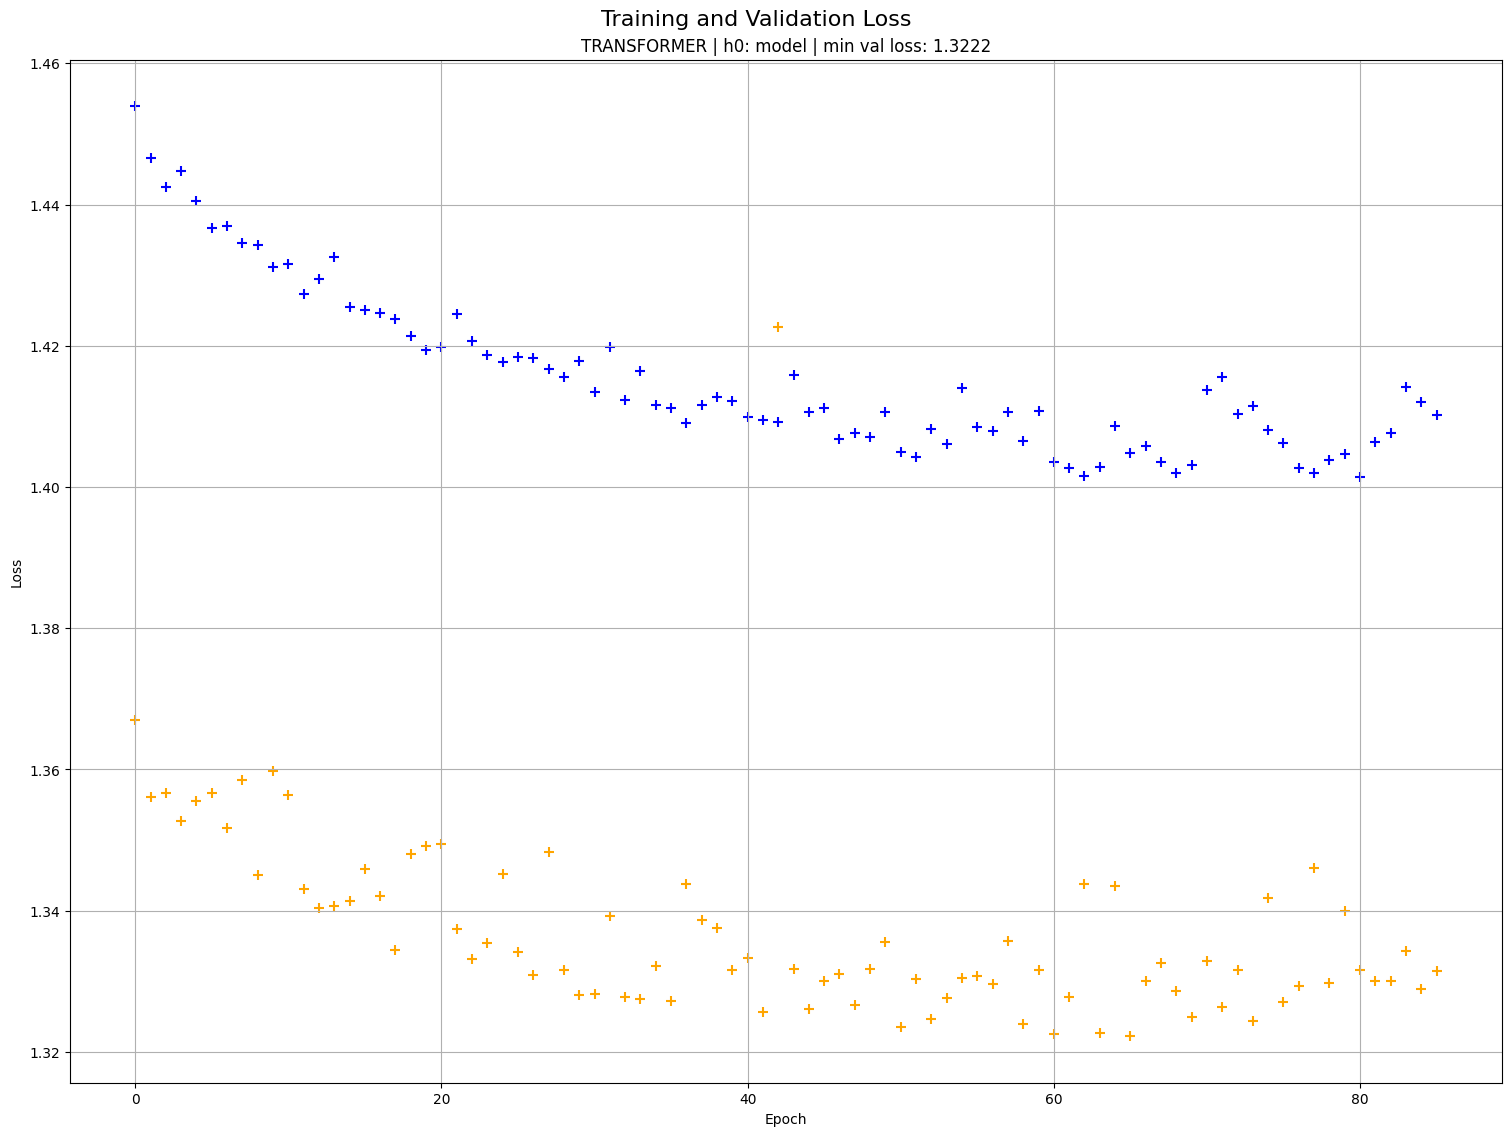

In [62]:
from proj_mod import visualization

train_loss_cut = train_loss[10:]
val_loss_cut = val_loss[10:]

vis_dict={("transformer","model"):{"train_loss": train_loss_cut,"val_loss": val_loss_cut}}
visualization.training_plots(vis_dict)